## Домашняя работа по теме: "Uplift моделирование"

Выполнила Моисеенкова Полина

Задание:
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

Failed to import duecredit due to No module named 'duecredit'
f:\anaconda\envs\python38\lib\site-packages\tqdm-4.64.1-py3.8.egg\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [4]:
# переименуем поля согласно заданию
df = df.rename(columns={'conversion': 'target'})
df = df.rename(columns={'offer': 'treatment'})

In [5]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [6]:
# привести поле treatment к бинарному виду
df['treatment'] = df['treatment'].map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})

In [7]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

### Feature engineering

In [8]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [9]:
# One-Hot Encoding:
df = pd.get_dummies(df)

In [10]:
def standard_scale(X):
    """Функция стандартизации"""

    mean = X.mean()
    std = X.std()
    return (X - mean) / std

def min_max_scale(X):
    """Для нормирования признаков"""

    return (X - X.min()) / (X.max() - X.min())

In [11]:
df['history'] = standard_scale(df['history'])
df['recency'] = min_max_scale(df['recency']) 
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,0.818182,-0.389000,1,0,0,1,0,0,1,0,0,1,0
1,0.454545,0.339611,1,1,1,0,0,1,0,0,0,0,1
2,0.545455,-0.239834,0,1,1,1,0,0,1,0,0,0,1
3,0.727273,1.693265,1,0,1,1,0,1,0,0,0,0,1
4,0.090909,-0.768062,1,0,0,1,0,0,0,1,0,0,1


In [12]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=42, test_size=0.3)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


### 1 способ uplift-моделирования: одна модель с признаком коммуникации (S learner)

iteritems is deprecated and will be removed in a future version. Use .items instead.


array([<AxesSubplot: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot: title={'center': 'Control predictions'}>,
       <AxesSubplot: title={'center': 'Uplift predictions'}>],
      dtype=object)

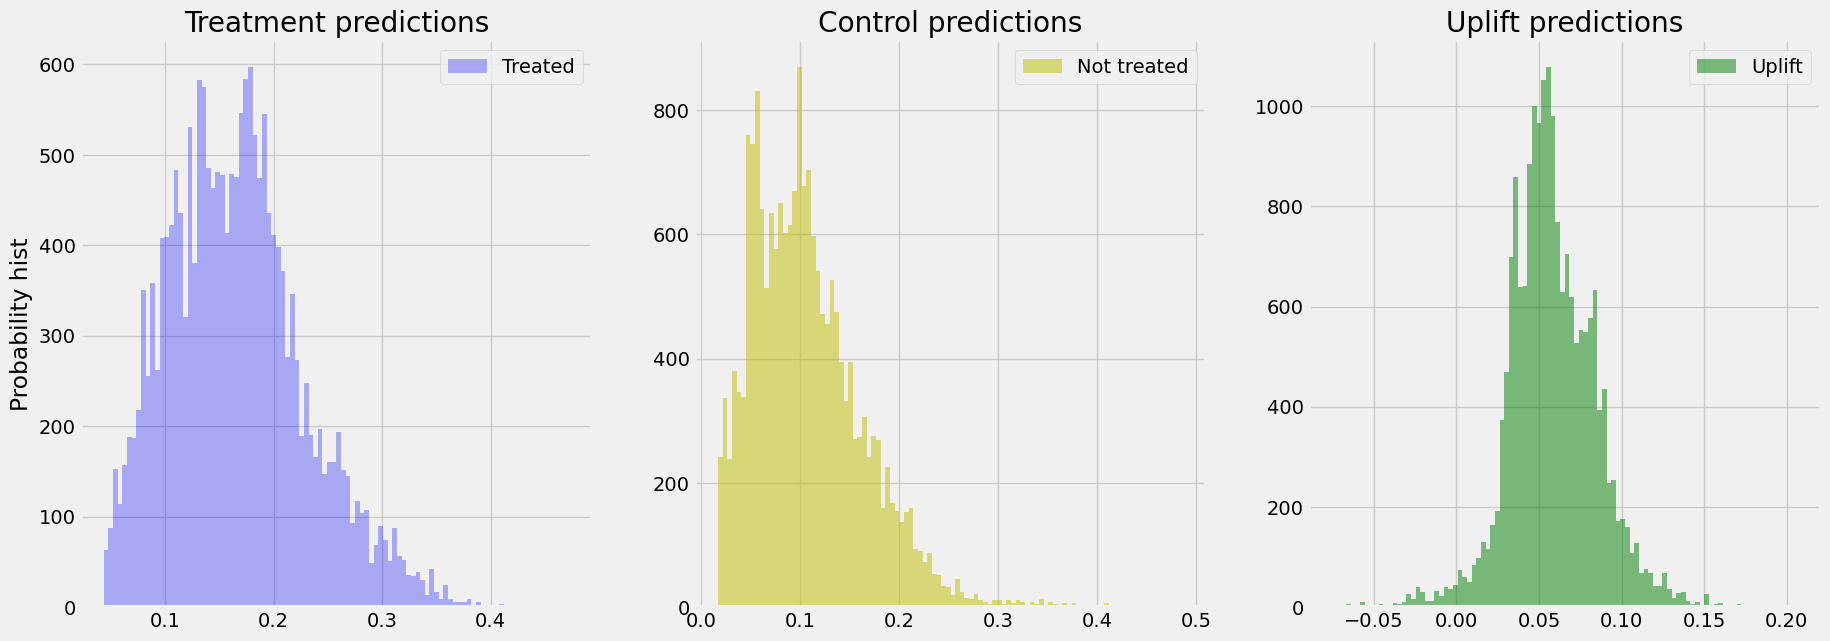

In [13]:
sm = SoloModel(catb.CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, X_train['treatment'])

uplift_sm = sm.predict(X_test)

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.2)

uplift = [sm_score10, sm_score20]

models_results = {
    'approach': [],
    'uplift': []
}
models_results['approach'].append('SoloModel')
models_results['uplift'].append(uplift)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

### 2 способ uplift-моделирования: модель с трансформацией таргета

In [14]:
ct = ClassTransformation(catb.CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, X_train['treatment'])

uplift_ct = ct.predict(X_test)

ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.2)

uplift = [ct_score10, ct_score20]

models_results['approach'].append('ClassTransformation')
models_results['uplift'].append(uplift)

iteritems is deprecated and will be removed in a future version. Use .items instead.


### 3 способ uplift-моделирования: 2 независимые модели

iteritems is deprecated and will be removed in a future version. Use .items instead.


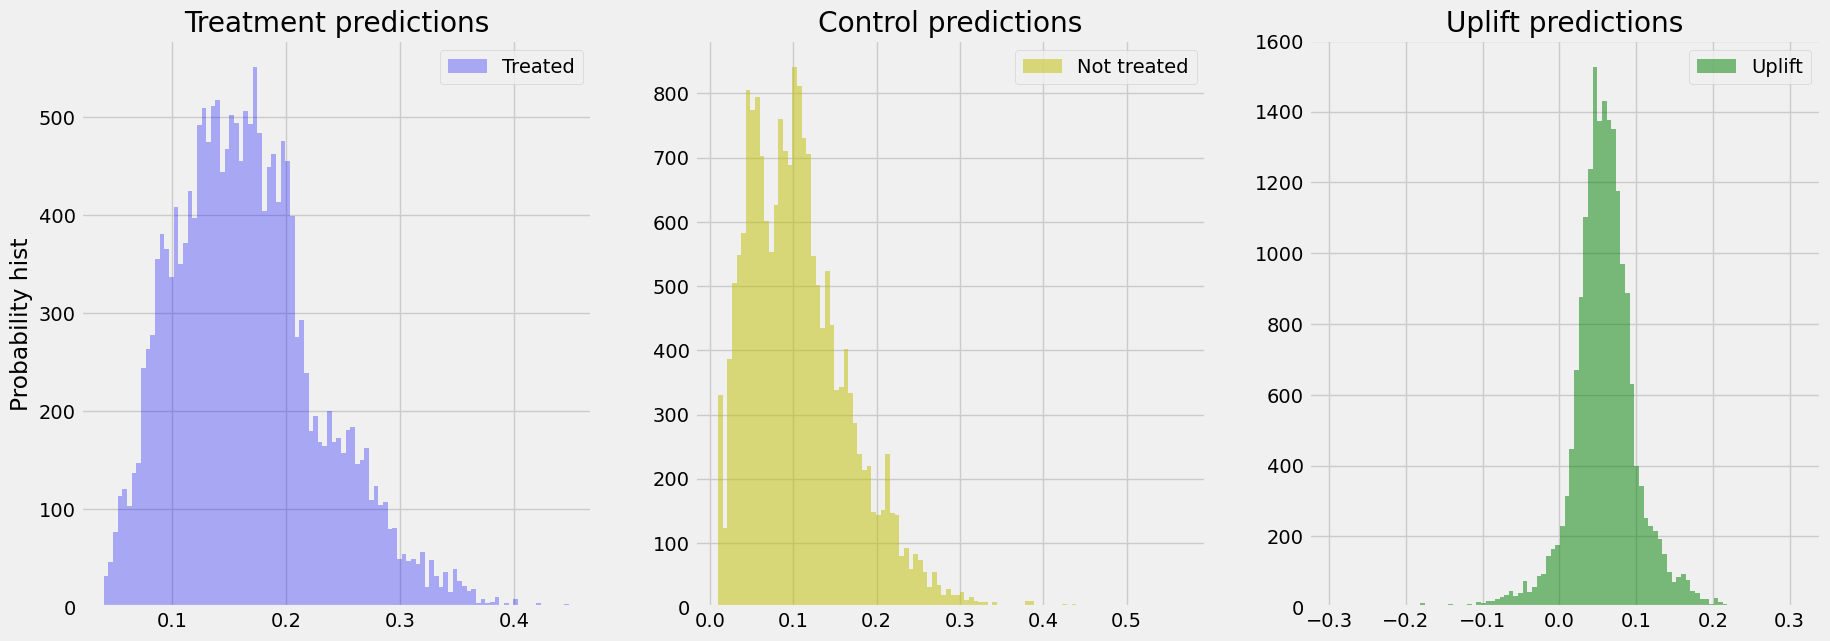

In [15]:
tm = TwoModels(
    estimator_trmnt=catb.CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=catb.CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, X_train['treatment'])

uplift_tm = tm.predict(X_test)

tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.2)

uplift = [tm_score10, tm_score20]

models_results['approach'].append('TwoModels')
models_results['uplift'].append(uplift)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [16]:
table = {'uplift@10%': [i[0] for i in models_results['uplift']],
        'uplift@20%': [i[1] for i in models_results['uplift']]}

table = pd.DataFrame(data=table, index=models_results['approach'])
table

,uplift@10%,uplift@20%
SoloModel,0.086985,0.093551
ClassTransformation,0.272591,0.225386
TwoModels,0.083775,0.081051


### Вариант с деревом решений